<font size = 6> Модель монетизации игрового приложения</font>

## Описание проекта

Многие игры зарабатывают с помощью рекламы. И все они сталкиваются с противоречием:
- Пользователь разозлится и уйдёт, если начать показывать ему рекламу раньше, чем игра его затянет.
- Но  чем позже создатели игры включат рекламу, тем меньше они заработают.

**Задача:** Сформировать модель монетизации игрового приложения.

Пока создатели игры планируют зарабатывать с помощью рекламы и показывать её на экране выбором постройки.

Зная расходы на продвижение игры, необходимо рассчитать её окупаемость при разных сценариях.


**Описание данных**  
Основной датасет *game_actions.csv*:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. building — объект построен,
    2. finished_stage_1 — первый уровень завершён,
    3. project — проект завершён;
- `building_type` — один из трёх типов здания:
    1. assembly_shop — сборочный цех,
    2. spaceport — космопорт,
    3. research_center — исследовательский центр;
- `user_i` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Датасеты с информацией о рекламных активностях.

Датасет *ad_cost.csv* :

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

Датасет *user_source.csv* :

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

## Получение данных

In [1]:
# Импорт необходимых библиотек
import pandas as pd
from datetime import datetime
from datetime import date
from datetime import timedelta
from io import BytesIO
import requests
import matplotlib.pyplot as plt
import seaborn as sns
# import numpy as np
import scipy.stats as stats
# from math import ceil
from tqdm import tqdm

In [2]:
# создадим словарь, где ключ - имя датасета, а значение - идентификатор таблицы на Google Disk
files_list = {'game_actions' : '******', 
              'ad_costs' : '******', 
              'user_source' : '******'}

In [3]:
# Читаем данные и выводим название, info и первые 2 строки
for df_name in files_list:
    
    try:
        globals()[df_name] = pd.read_csv(df_name + ".csv")
    except FileNotFoundError:
        spreadsheet_id = files_list[df_name]
        file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
        r = requests.get(file_name)
        globals()[df_name] = pd.read_csv(BytesIO(r.content))
                  
    print(50*'>', df_name)
    globals()[df_name].info()
    display(globals()[df_name].head(2))
    print()

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> game_actions
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ad_costs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480



>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> user_source
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct


**Выводы**  
- game_actions 135640 записей, пропуски в столбцах `building_type` и `project_type` обусловлены ограниченныи числом значений категориальных переменных. Тип строения может быть только у события постройка, а тип проекта по условию только один и может быть только у проекта, требуется изменение типа по столбцу `event_datetime`
- ad_costs 28 записей, пропуски отсутствуют, требуется изменение типа по столбцу `day`
- user_source 13576 записей, пропуски отсутствуют, изменение типа данных не требуется

## Предобработка данных

### Датасет `game_actions`

Проверим доступные сзначения столбцов `event`, `building_type`, `project_type`

In [4]:
game_actions['event'].value_counts()

building            127957
finished_stage_1      5817
project               1866
Name: event, dtype: int64

In [5]:
game_actions['building_type'].value_counts()

spaceport          59325
assembly_shop      54494
research_center    14138
Name: building_type, dtype: int64

In [6]:
game_actions['project_type'].value_counts()

satellite_orbital_assembly    1866
Name: project_type, dtype: int64

Ошибок не выявлено

Посмотрим у каких `event` есть пропуски в `building_type`

In [7]:
game_actions.loc[game_actions['building_type'].isna()]['event'].unique()

array(['finished_stage_1', 'project'], dtype=object)

Пропуски только у событий `finished_stage_1` и `project`. Данные корректны.

Посмотрим у каких `event` есть пропуски в `project_type`

In [8]:
game_actions.loc[game_actions['project_type'].isna()]['event'].unique()

array(['building', 'finished_stage_1'], dtype=object)

Пропуски только у событий `building` и `finished_stage_1`. Данные корректны.

Проверим дубликаты

In [9]:
game_actions.duplicated().sum()

1

Найден 1 думликат. Посмотрим на него.

In [10]:
game_actions.loc[game_actions.duplicated()]

,event_datetime,event,building_type,user_id,project_type
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


Выведем все записи с `event_datetime` = 2020-05-10 18:41:56

In [11]:
game_actions.query('event_datetime == "2020-05-10 18:41:56"')

,event_datetime,event,building_type,user_id,project_type
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


Идентичное действие для одного пользователя, индексы записей последовательны. Считаем программной ошибкой, дубликаат удаляем.

In [12]:
game_actions = game_actions.drop_duplicates().reset_index(drop=True)
# проверка
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135639 entries, 0 to 135638
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135639 non-null  object
 1   event           135639 non-null  object
 2   building_type   127956 non-null  object
 3   user_id         135639 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


Изменим тип данных для `event_datetime`

In [13]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'], format='%Y-%m-%d %H:%M:%S')
# проверка
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135639 entries, 0 to 135638
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   127956 non-null  object        
 3   user_id         135639 non-null  object        
 4   project_type    1866 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 5.2+ MB


Проверим диапазон дат в датасете

In [14]:
print('Первая дата    :', game_actions['event_datetime'].min())
print('Последняя дата :', game_actions['event_datetime'].max())

Первая дата    : 2020-05-04 00:00:01
Последняя дата : 2020-06-05 12:32:49


### Датасет `ad_costs`

Проверим доступные сзначения столбцов `source`

In [15]:
ad_costs['source'].value_counts()

instagram_new_adverts      7
youtube_channel_reklama    7
yandex_direct              7
facebook_ads               7
Name: source, dtype: int64

Проверим дубликаты

In [16]:
ad_costs.duplicated().sum()

0

Изменим тип данных для `event_datetime`

In [17]:
ad_costs['day'] = pd.to_datetime(ad_costs['day'], format='%Y-%m-%d')
# ad_costs['cost'] = ad_costs['cost'].astype(float)
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   source  28 non-null     object        
 1   day     28 non-null     datetime64[ns]
 2   cost    28 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 800.0+ bytes


Проверим диапазон дат в датасете

In [18]:
print('Первая дата    :', ad_costs['day'].min())
print('Последняя дата :', ad_costs['day'].max())

Первая дата    : 2020-05-03 00:00:00
Последняя дата : 2020-05-09 00:00:00


По условию, "В датасетах содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно." Поэтому, полагаем, что в данных ошибка и они сдвинуты на день (подтверждено тимлидом). Скорректируем данные.

In [19]:
ad_costs['day'] = ad_costs['day'] + timedelta(days=1)
# проверка
print('Первая дата    :', ad_costs['day'].min())
print('Последняя дата :', ad_costs['day'].max())

Первая дата    : 2020-05-04 00:00:00
Последняя дата : 2020-05-10 00:00:00


### Датасет `user_source`

Проверим доступные сзначения столбцов `source`

In [20]:
user_source['source'].value_counts()

yandex_direct              4817
instagram_new_adverts      3347
facebook_ads               2726
youtube_channel_reklama    2686
Name: source, dtype: int64

Проверим дубликаты

In [21]:
user_source.duplicated().sum()

0

Замена типов данных не требуется.

**Выводы** Данные подготовлены для анализа. Произведена проверка, обработка пропусков, удаление дубликатов, изменение типа, корректировка.

## Исследовательский анализ данных

###  Структура игроков

In [22]:
# число уникальных пользователей
total_users = game_actions['user_id'].nunique()
total_users

13576

In [23]:
# список пользователей завершивших первый уровень
users_finished = game_actions.query('event == "finished_stage_1"')['user_id'].to_list()
# число пользователей завершивших первый уровень
st_com_users = len(users_finished)
st_com_users

5817

In [24]:
# список пользователей реализовавших проект
users_with_project = game_actions.query('project_type == "satellite_orbital_assembly"')['user_id'].to_list()
# список пользователей завершивших уровень победой
users_finished_wo_project = (
    game_actions.query('user_id not in @users_with_project and event == "finished_stage_1"')['user_id']).to_list()
# число пользователей реализовавших проект (PvE)
pve_users = len(users_with_project)
print('Число пользователей реализовавших проект', pve_users)
# число пользователей реализовавших проект и завершивших уровень
print(
    'Число пользователей реализовавших проект и завершивших уровень', 
    game_actions.query('user_id in @users_with_project and event == "finished_stage_1"')['user_id'].count())

Число пользователей реализовавших проект 1866
Число пользователей реализовавших проект и завершивших уровень 1866


Все пользователи реализовавшие проект, закончили уровень.

In [25]:
# число пользователей завершивших победой (PvP)
pvp_users = st_com_users - pve_users
pvp_users

3951

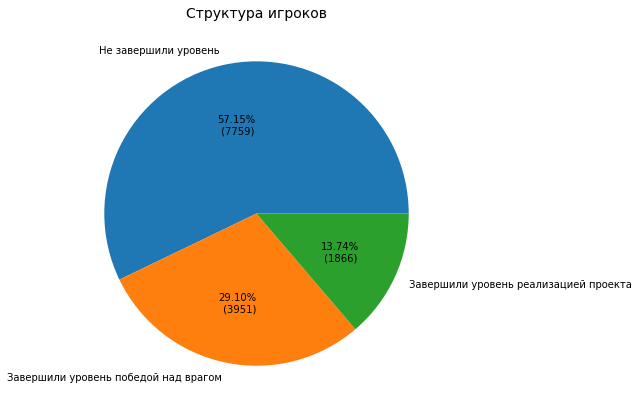

In [26]:
# визуализируем структуру игроков
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n ({v:d})'.format(p=pct,v=val)
    return my_autopct

values = [total_users - st_com_users, pvp_users, pve_users]
plt.figure(figsize=(7,7))
plt.pie(
    values, 
    labels = ["Не завершили уровень", "Завершили уровень победой над врагом", "Завершили уровень реализацией проекта"], 
    autopct = make_autopct(values))
plt.title('Структура игроков', fontsize=14)
plt.show()

**Выводы** Из 13576 игроков около 43% (5817) завершили уровень. Доля игроков с PvE около 14%, а PvP - 29%

### Распреседение игроков по числу событий

In [27]:
# функция для определения типа игрока: закончил уровень проектом, закончил уровень победой, не закончил уровень
def us_type(user_id):
    if user_id in users_with_project: return 'finished_pve'
    elif user_id in users_finished_wo_project: return 'finished_pvp'
    else: return 'not_finished'

In [28]:
# число событий по пользователям
ev_by_users = game_actions['user_id'].value_counts().reset_index().rename(columns={'index':'user_id', 'user_id':'ev_no'})

# дополнительный столбец с типом игрока  
tqdm.pandas()
ev_by_users['user_type'] = ev_by_users['user_id'].progress_apply(us_type)
ev_by_users.head(2)

100%|██████████████████████████████████| 13576/13576 [00:04<00:00, 2976.60it/s]


,user_id,ev_no,user_type
0,bf542075-e3a2-4e79-82d8-3838e86d2a25,22,finished_pve
1,ff841992-d93b-462e-bc6e-18c24a514f36,22,finished_pve


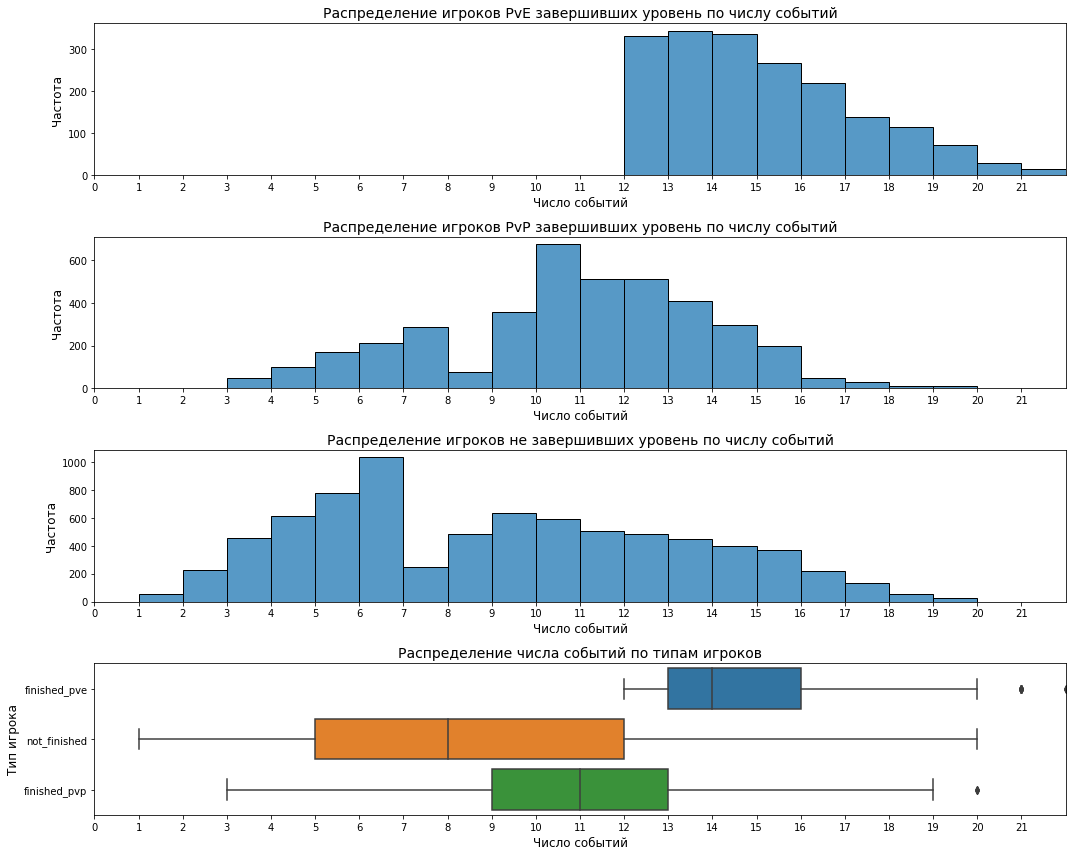

In [29]:
# визуализируем
fig42 = plt.figure(figsize=(15,12))
ax1 = fig42.add_subplot(4,1,1)
ax2 = fig42.add_subplot(4,1,2)
ax3 = fig42.add_subplot(4,1,3)
ax4 = fig42.add_subplot(4,1,4)

sns.histplot(x='ev_no', data=ev_by_users.query('user_type == "finished_pve"'), bins=22, binwidth = 1, ax = ax1)
ax1.set_title('Распределение игроков PvE завершивших уровень по числу событий', fontsize=14)
ax1.set_xlabel('Число событий', fontsize=12)
ax1.set_ylabel('Частота', fontsize=12)
ax1.set_xticks([x for x in range(0, 22)])
ax1.set_xlim(0, 22)

sns.histplot(x='ev_no', data=ev_by_users.query('user_type == "finished_pvp"'), bins=22, binwidth = 1, ax = ax2)
ax2.set_title('Распределение игроков PvР завершивших уровень по числу событий', fontsize=14)
ax2.set_xlabel('Число событий', fontsize=12)
ax2.set_ylabel('Частота', fontsize=12)
ax2.set_xticks([x for x in range(0, 22)])
ax2.set_xlim(0, 22)

sns.histplot(x='ev_no', data=ev_by_users.query('user_type == "not_finished"'), bins=22, binwidth = 1, ax = ax3)
ax3.set_title('Распределение игроков не завершивших уровень по числу событий', fontsize=14)
ax3.set_xlabel('Число событий', fontsize=12)
ax3.set_ylabel('Частота', fontsize=12)
ax3.set_xticks([x for x in range(0, 22)])
ax3.set_xlim(0, 22)

sns.boxplot(x="ev_no", y="user_type", data=ev_by_users, ax = ax4)
ax4.set_title('Распределение числа событий по типам игроков', fontsize=14)
ax4.set_xlabel('Число событий', fontsize=12)
ax4.set_ylabel('Тип игрока', fontsize=12)
ax4.set_xticks([x for x in range(0, 22)])
ax4.set_xlim(0, 22)

fig42.tight_layout()

**Выводы**
- *PvE* От 12 жо 22 событий с медианой 14.
- *PvP* От 3 до 20 событий с медианой 11.
- *Игроки не завершившие уровень* От 1 до 20 событий с медианой 8. 

Число событий по типам

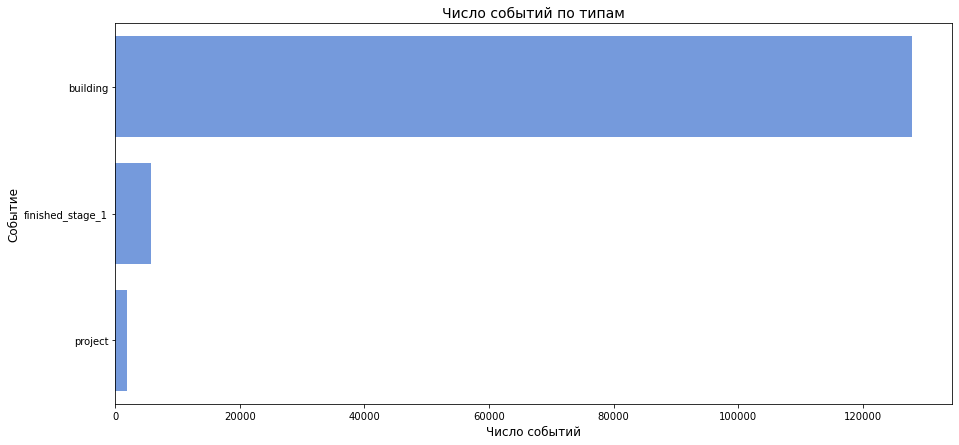

In [30]:
plt.figure(figsize=(15,7))
sns.barplot(y='index', x='event', data=game_actions['event'].value_counts().reset_index(), color='cornflowerblue')
plt.title('Число событий по типам', fontsize=14)
plt.xlabel('Число событий', fontsize=12)
plt.ylabel('Событие', fontsize=12)
plt.show()

Большая доля всех событий - постройка

### Активность игроков по дням

In [31]:
# активность(число event) по дням
game_actions['event_date'] = pd.DatetimeIndex(game_actions['event_datetime']).date

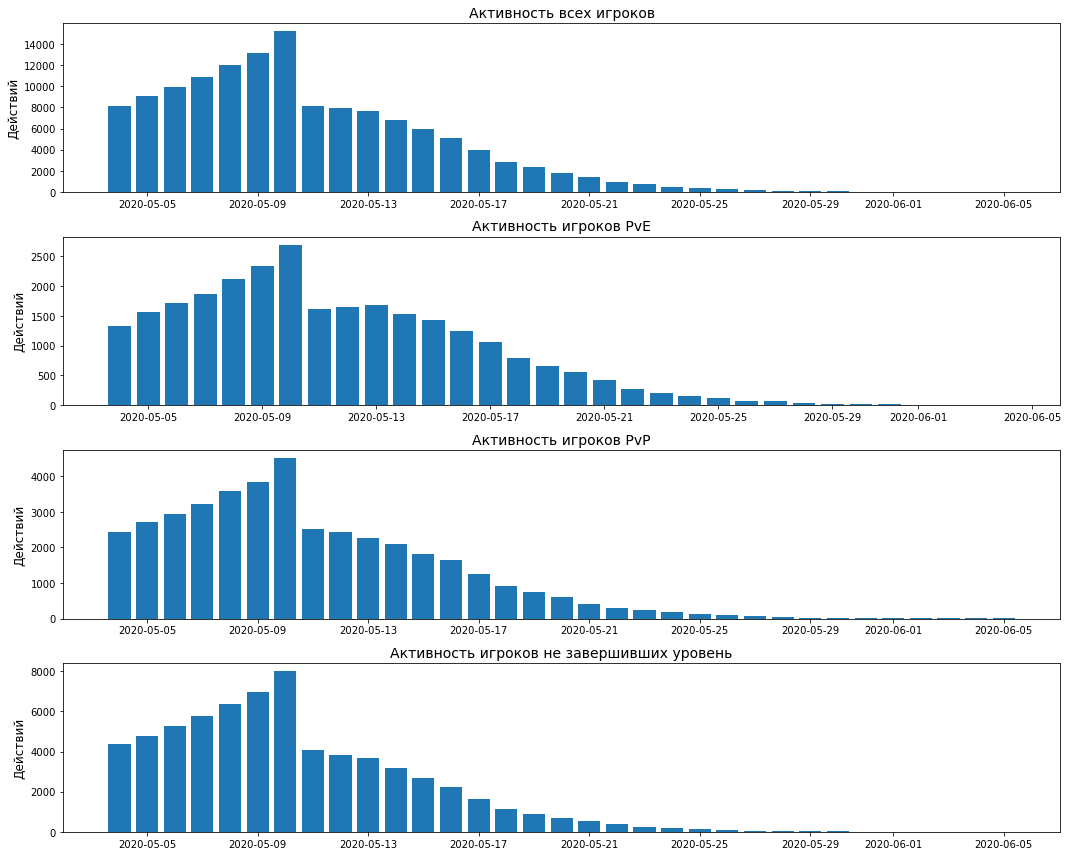

In [32]:
# визуализируем
fig43 = plt.figure(figsize=(15,12))
ax1 = fig43.add_subplot(4,1,1)
ax2 = fig43.add_subplot(4,1,2)
ax3 = fig43.add_subplot(4,1,3)
ax4 = fig43.add_subplot(4,1,4)

ax1.bar(
    x = 'event_date', 
    height = 'user_id', 
    data = game_actions.groupby('event_date').agg({'user_id':'count'}).reset_index())
ax1.set_title('Активность всех игроков', fontsize=14)
ax1.set_xlabel('', fontsize=12)
ax1.set_ylabel('Действий', fontsize=12)

ax2.bar(
    x = 'event_date', 
    height = 'user_id', 
    data = game_actions.query('user_id in @users_with_project').groupby('event_date').agg({'user_id':'count'}).reset_index())
ax2.set_title('Активность игроков PvE', fontsize=14)
ax2.set_xlabel('', fontsize=12)
ax2.set_ylabel('Действий', fontsize=12)

ax3.bar(
    x = 'event_date', 
    height = 'user_id', 
    data = game_actions.query('user_id in @users_finished_wo_project').groupby('event_date').agg({'user_id':'count'}).reset_index())
ax3.set_title('Активность игроков PvP', fontsize=14)
ax3.set_xlabel('', fontsize=12)
ax3.set_ylabel('Действий', fontsize=12)

ax4.bar(
    x = 'event_date', 
    height = 'user_id', 
    data = game_actions.query('user_id not in @users_finished').groupby('event_date').agg({'user_id':'count'}).reset_index())
ax4.set_title('Активность игроков не завершивших уровень', fontsize=14)
ax4.set_xlabel('', fontsize=12)
ax4.set_ylabel('Действий', fontsize=12)

fig43.tight_layout()

**Выводы** Активность игроков растёт в период рекламы (с 1 по 10 число) после чего затухает. Динамика активности в разрезе по типам игроков практически идентична. Стоит отметить, что дольше всего сохраняется ативность игроков PvP, вплоть до 05-06-2020.

### Распределение игроков по числу построек

In [33]:
# всего запусков построек
game_actions.query('event == "building"')['event'].count()

127956

In [34]:
# число событий по пользователям
bl_by_users = (
    game_actions.query('event == "building"')['user_id']
    .value_counts()
    .reset_index()
    .rename(columns={'index':'user_id', 'user_id':'bl_no'}))

# дополнительный столбец с типом игрока  
tqdm.pandas()
bl_by_users['user_type'] = bl_by_users['user_id'].progress_apply(us_type)
bl_by_users.head(2)

100%|██████████████████████████████████| 13576/13576 [00:04<00:00, 3173.02it/s]


,user_id,bl_no,user_type
0,b8a01939-eb2d-4021-a1fb-c3f2a52fa176,20,not_finished
1,a5add3ce-1ac4-4b97-aba0-f040efc4c1b0,20,not_finished


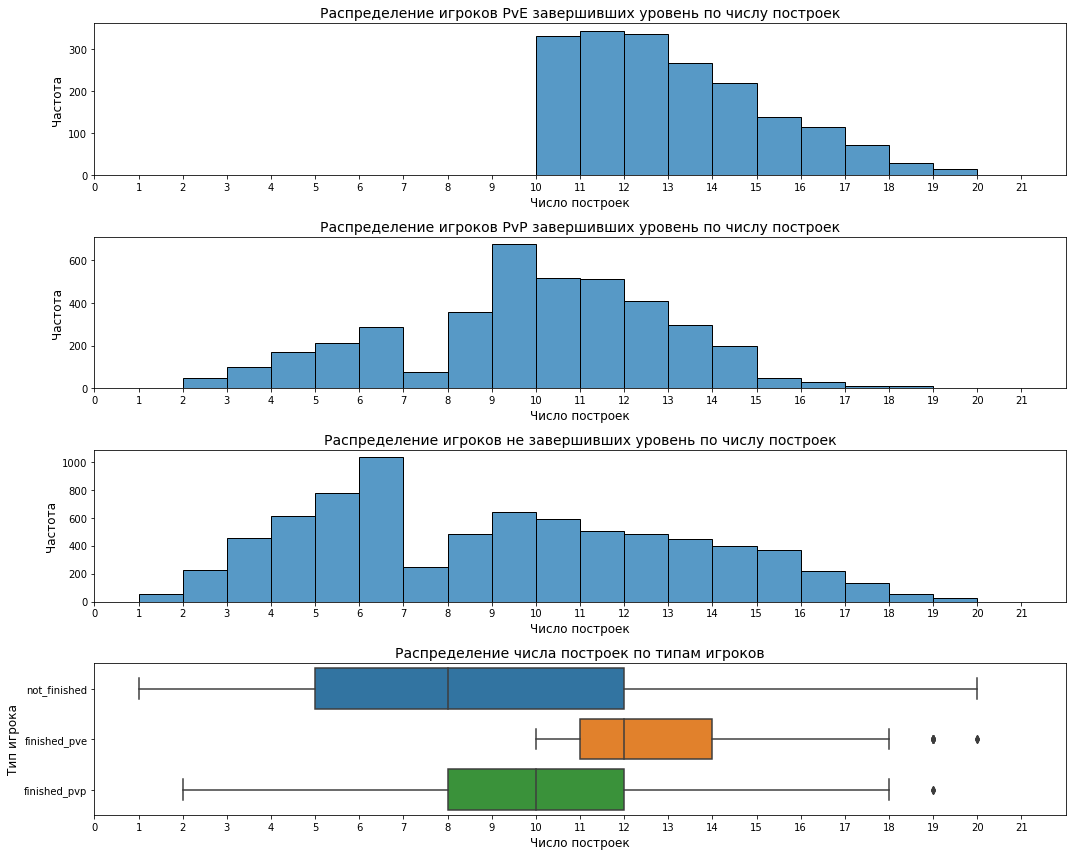

In [35]:
# визуализируем
fig42 = plt.figure(figsize=(15,12))
ax1 = fig42.add_subplot(4,1,1)
ax2 = fig42.add_subplot(4,1,2)
ax3 = fig42.add_subplot(4,1,3)
ax4 = fig42.add_subplot(4,1,4)

sns.histplot(x='bl_no', data=bl_by_users.query('user_type == "finished_pve"'), bins=22, binwidth = 1, ax = ax1)
ax1.set_title('Распределение игроков PvE завершивших уровень по числу построек', fontsize=14)
ax1.set_xlabel('Число построек', fontsize=12)
ax1.set_ylabel('Частота', fontsize=12)
ax1.set_xticks([x for x in range(0, 22)])
ax1.set_xlim(0, 22)

sns.histplot(x='bl_no', data=bl_by_users.query('user_type == "finished_pvp"'), bins=22, binwidth = 1, ax = ax2)
ax2.set_title('Распределение игроков PvР завершивших уровень по числу построек', fontsize=14)
ax2.set_xlabel('Число построек', fontsize=12)
ax2.set_ylabel('Частота', fontsize=12)
ax2.set_xticks([x for x in range(0, 22)])
ax2.set_xlim(0, 22)

sns.histplot(x='bl_no', data=bl_by_users.query('user_type == "not_finished"'), bins=22, binwidth = 1, ax = ax3)
ax3.set_title('Распределение игроков не завершивших уровень по числу построек', fontsize=14)
ax3.set_xlabel('Число построек', fontsize=12)
ax3.set_ylabel('Частота', fontsize=12)
ax3.set_xticks([x for x in range(0, 22)])
ax3.set_xlim(0, 22)

sns.boxplot(x="bl_no", y="user_type", data=bl_by_users, ax = ax4)
ax4.set_title('Распределение числа построек по типам игроков', fontsize=14)
ax4.set_xlabel('Число построек', fontsize=12)
ax4.set_ylabel('Тип игрока', fontsize=12)
ax4.set_xticks([x for x in range(0, 22)])
ax4.set_xlim(0, 22)

fig42.tight_layout()

**Выводы**
- *PvE* от 10 до 18 построек с медианой 12 и двумя выбросами, 19 и 20.
- *PvP* от 2 до 18 построек с медианой 10 и выбросом 19. Диаграмма размаха симметрична.
- *Игроки не завершившие уровень* от 1 до 20 построек с медианой 8. 
Для групп, кроме PvE характерен "провал" по числу игроков с 7 постройками. Разница между числом игроков с 6 и 7 постройками почти в четырехкратная. Более 25% игроков не завершивших уровень и завершивших уровень PvP, потенциально могли его завершить стратегией PvE, так как у таких игроков более 12 построек, что выше медианного значения числа построек игроков, завершивших уровень PvE. 25% игроков не завершивших уровень имели столько же построек, сколько 50% завершивших уровень PvP.

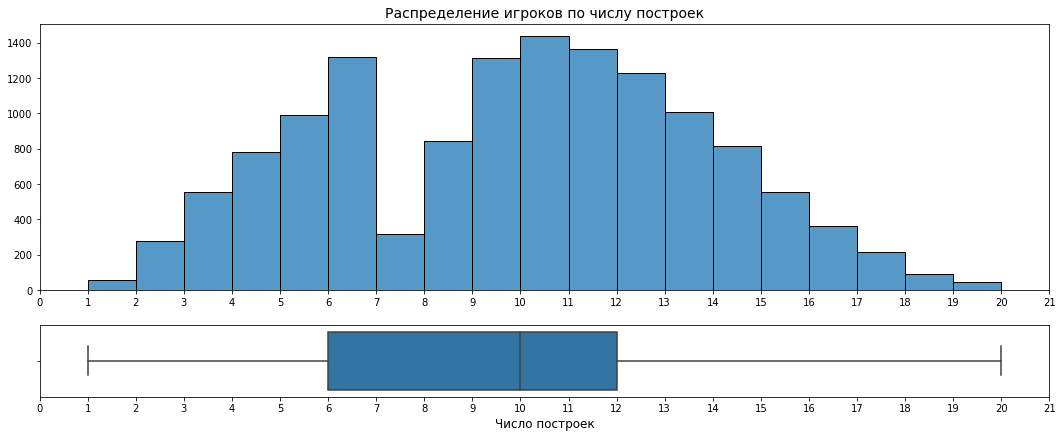

In [36]:
# число игроков по числу построек без разбивки по типу
fig44 = plt.figure(figsize=(15,12))
ax1 = fig44.add_subplot(2,1,1)
ax2 = fig44.add_subplot(6,1,3)

sns.histplot(
    x="event",
    data=(
        game_actions.query('event == "building"')
        .groupby('user_id').agg({'event':'count'}).reset_index()
         ),
    binwidth = 1, 
    ax = ax1)
ax1.set_title('Распределение игроков по числу построек', fontsize=14)
ax1.set_xlabel('  ', fontsize=12)
ax1.set_ylabel('', fontsize=12)
ax1.set_xticks([x for x in range(0, 22)])

sns.boxplot(
    x="event",
    data=(
        game_actions.query('event == "building"')
        .groupby('user_id').agg({'event':'count'}).reset_index()
         ),
    ax = ax2)

ax2.set_xlabel('Число построек', fontsize=12)
ax2.set_ylabel('', fontsize=12)
ax2.set_xticks([x for x in range(0, 22)])

fig44.tight_layout()

Все игроки хотя бы раз запускали постройку, 75% игроков делало это более 6 раз, а половина от 6 до 12 раз.

### Профили игроков

In [37]:
# создадим профили игроков
# даты первого захода игрока
profiles = game_actions.groupby('user_id').agg({'event_datetime':'min'}).reset_index()
profiles['event_datetime'] = pd.DatetimeIndex(profiles['event_datetime']).date
profiles = pd.merge(profiles, user_source, on='user_id')
profiles.head()

,user_id,event_datetime,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05,facebook_ads


In [38]:
# распределение игроков по датам привлечения
profiles.groupby('event_datetime').agg({'user_id':'count'})

,user_id
event_datetime,
2020-05-04,5860
2020-05-05,3361
2020-05-06,1847
2020-05-07,1109
2020-05-08,688
2020-05-09,440
2020-05-10,271


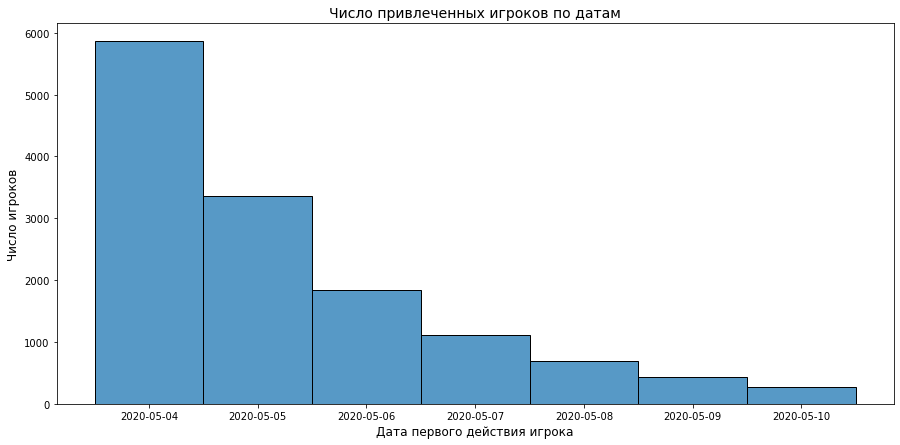

In [39]:
# визуализируем
plt.figure(figsize=(15,7))
sns.histplot(x = 'event_datetime', data = profiles, bins=7)
plt.title('Число привлеченных игроков по датам', fontsize=14)
plt.xlabel('Дата первого действия игрока', fontsize=12)
plt.ylabel('Число игроков', fontsize=12)
plt.show()

Больше всего игроков, почти 6000, привлечено в первый день (04-05-2020). Дальше наблюдается равномерное снижение с коэффицентом 0.55-0.65 до 270 (10-05-2020).

In [40]:
# в разбивке по каналам
users_by_days = profiles.groupby(['source', 'event_datetime']).agg({'user_id':'count'}).reset_index()
users_by_days.head(2)

,source,event_datetime,user_id
0,facebook_ads,2020-05-04,1184
1,facebook_ads,2020-05-05,694


In [41]:
# добавим стоимость рекламы по каналу и дате
users_by_days['event_datetime'] = pd.to_datetime(users_by_days['event_datetime'], format='%Y-%m-%d')
users_by_days = users_by_days.merge(ad_costs, left_on=['source','event_datetime'], right_on = ['source','day'], how="left")

In [42]:
# стоимость привлечения игрока по дате и каналу
users_by_days['cost_per_user'] = users_by_days['cost'] / users_by_days['user_id']
users_by_days.head(2)

,source,event_datetime,user_id,day,cost,cost_per_user
0,facebook_ads,2020-05-04,1184,2020-05-04,935.882786,0.790442
1,facebook_ads,2020-05-05,694,2020-05-05,548.354480,0.790136


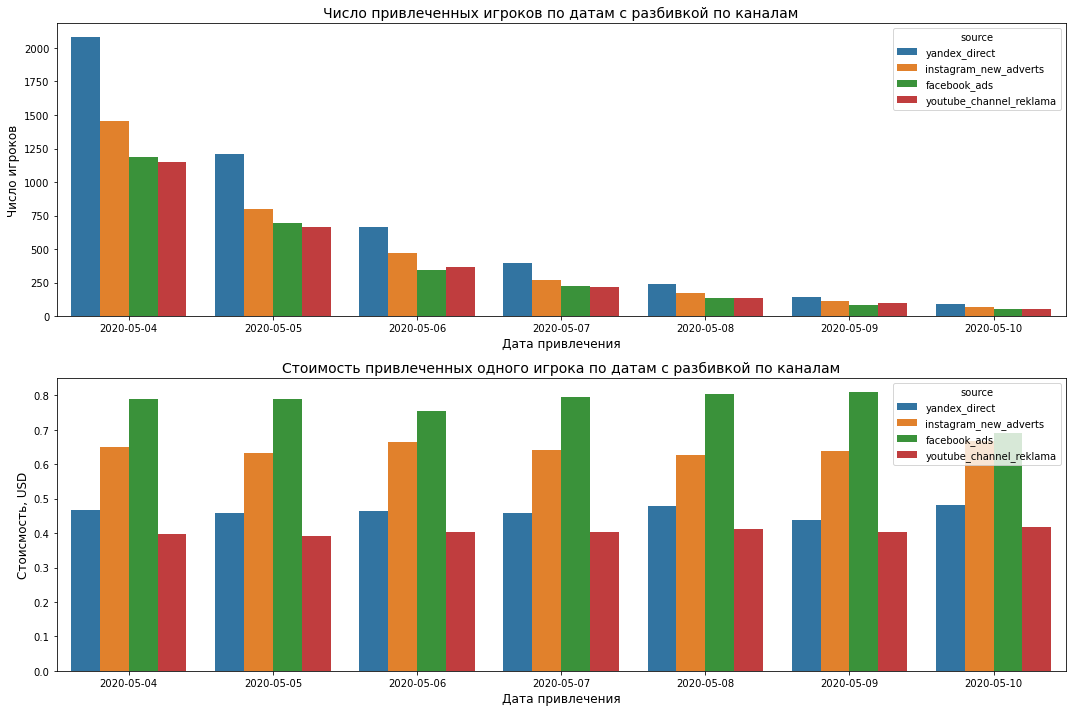

In [43]:
# визуализируем
fig45 = plt.figure(figsize=(15,10))
ax1 = fig45.add_subplot(2,1,1)
ax2 = fig45.add_subplot(2,1,2)

sns.barplot(
    x = pd.DatetimeIndex(users_by_days['event_datetime']).date, 
    y = 'user_id', 
    data = users_by_days, 
    hue='source', 
    hue_order=('yandex_direct', 'instagram_new_adverts', 'facebook_ads', 'youtube_channel_reklama'),
    ax = ax1)
ax1.set_title('Число привлеченных игроков по датам c разбивкой по каналам', fontsize=14)
ax1.set_xlabel('Дата привлечения', fontsize=12)
ax1.set_ylabel('Число игроков', fontsize=12)

sns.barplot(
    x = pd.DatetimeIndex(users_by_days['event_datetime']).date, 
    y = users_by_days['cost_per_user'], 
    data = users_by_days, 
    hue='source', 
    hue_order=('yandex_direct', 'instagram_new_adverts', 'facebook_ads', 'youtube_channel_reklama'),
    ax = ax2)
ax2.set_title('Стоимость привлеченных одного игрока по датам c разбивкой по каналам', fontsize=14)
ax2.set_xlabel('Дата привлечения', fontsize=12)
ax2.set_ylabel('Стоисмость, USD', fontsize=12)

fig45.tight_layout()

* Больше всего игроков привлечено через yandex_direct, далее instagram_new_adverts и facebook_ads с youtube_channel_reklama. Первые 2 лидируют во все дни, последние 2 показывают примерно одинаковый результат. В первые 2-3 дня yandex_direct лидирует с существенным отрывом.  
* Самые дорогие каналы по стоимость привлечения - instagram_new_adverts и facebook_ads. Самый дешевый - youtube_channel_reklama. Стоимость привлечения одного игрока почти постоянна и не меняется во времени. 
* С точки зрения эффективности вложений, в лидерах yandex_direct. Так же стоит обратить внимание на youtube_channel_reklama. Хотя, канал и занимает 3-4 места по числу привлеченных клиентов, стоимость привлечения самая низкая, а самое значительное отставание по числу привлеченных игроков от instagram_new_adverts 20% (04-05-2020)

In [44]:
# добавим данные в профайлы
profiles['event_datetime'] = pd.to_datetime(profiles['event_datetime'], format='%Y-%m-%d')
profiles = profiles.merge(
    users_by_days, 
    left_on=['source','event_datetime'], 
    right_on = ['source','event_datetime'], 
    how="left")
profiles.head(2)

,user_id_x,event_datetime,source,user_id_y,day,cost,cost_per_user
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,facebook_ads,345,2020-05-06,260.185754,0.754162
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06,yandex_direct,664,2020-05-06,308.232990,0.464206


In [45]:
# переименуем столбцы
profiles = profiles.rename(columns={'user_id_x' : 'user_id', 'event_datetime' : 'first_ts', 'user_id_y' : 'cohort_size'})
# удалим лишнее
profiles.drop(columns=['day', 'cost'], inplace=True)
profiles.head(2)

,user_id,first_ts,source,cohort_size,cost_per_user
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,facebook_ads,345,0.754162
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06,yandex_direct,664,0.464206


### Модель монетезации

In [46]:
# посмотрим на основные данные по `cost_per_user`
profiles['cost_per_user'].describe()

count    13576.000000
mean         0.560075
std          0.143726
min          0.390759
25%          0.459149
50%          0.466381
75%          0.649590
max          0.809634
Name: cost_per_user, dtype: float64

Средняя (медианная) стоимость привлечения игрока 0.46. Таким образом, для окупаемости, в среднем игроки должны строить не менее 7 (0.46/0.07) строений (т.е. просматривать рекламу 7 раз). Текущий показатель (медиана) 10. Можем предположить, что игра перестанет окупаться, при третьей постройке (первый показ рекламы - третья постройка).  
Провериим это. Добавим число построек для каждого игрока. И расчитаем для него 5 вариантов, показ рекламы с 1-5 постройки.

In [47]:
#добавим число построек для каждого игрока
buildings_by_users = (
    game_actions.query('event == "building"')
    .groupby('user_id').agg({'event':'count'})
    .reset_index())
df = pd.merge(profiles, buildings_by_users, on='user_id', how='left')
df = df.rename(columns={'event' : 'buildings'})
# добавим тип игрока
df = df.merge(ev_by_users.loc[:, ['user_id', 'user_type']], on='user_id', how='left')
df.head(2)

,user_id,first_ts,source,cohort_size,cost_per_user,buildings,user_type
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,facebook_ads,345,0.754162,13,not_finished
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06,yandex_direct,664,0.464206,9,not_finished


Для каждого игрока добывим 5 столбцов (вариантов). Расчитаем сумму заработка на игроке при показе реклямы начинас с 1,2..5 построек. Если у игрока, например 2 постройки, то при условии паказа рекламы с 3 постройки, на таком игроке заработка не будет.

In [48]:
for i in range(1, 6):
    col_name = 'ltv_' + str(i)
    df[col_name] = (df['buildings'] - (i-1))*0.07
    # если число построект игрока < i, то заработок на игроке 0
    df[col_name] = df[col_name].mask(df[col_name] < 0, 0)
df.head()

,user_id,first_ts,source,cohort_size,cost_per_user,buildings,user_type,ltv_1,ltv_2,ltv_3,ltv_4,ltv_5
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,facebook_ads,345,0.754162,13,not_finished,0.91,0.84,0.77,0.70,0.63
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06,yandex_direct,664,0.464206,9,not_finished,0.63,0.56,0.49,0.42,0.35
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,2020-05-05,youtube_channel_reklama,663,0.390759,4,not_finished,0.28,0.21,0.14,0.07,0.00
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05,instagram_new_adverts,796,0.631816,8,finished_pvp,0.56,0.49,0.42,0.35,0.28
4,002f508f-67b6-479f-814b-b05f00d4e995,2020-05-05,facebook_ads,694,0.790136,12,not_finished,0.84,0.77,0.70,0.63,0.56


Общий доход для каждого из 5 вариантов

In [49]:
for i in range(1, 6):
    col_name = 'ltv_' + str(i)
    income = round(df[col_name].sum() - df['cost_per_user'].sum(), 2)
    print(f'При показе рекламы с {i} постройки, доход {income}')

При показе рекламы с 1 постройки, доход 1353.34
При показе рекламы с 2 постройки, доход 403.02
При показе рекламы с 3 постройки, доход -543.31
При показе рекламы с 4 постройки, доход -1470.18
При показе рекламы с 5 постройки, доход -2358.13


Что бы вложения в рекламу окупались, нужно начинать показ рекламы не позже 2-ой стройки.

Определим доходность по каналам привлечения

In [50]:
dft = (
    df.groupby('source')
    .agg(
        {'cost_per_user':'sum', 
         'ltv_1' : 'sum', 
         'ltv_2' : 'sum', 
         'ltv_3' : 'sum', 
         'ltv_4' : 'sum', 
         'ltv_5' : 'sum'})).reset_index()
dft.index = dft['source']
dft.drop(columns='source', inplace=True)
dft

,cost_per_user,ltv_1,ltv_2,ltv_3,ltv_4,ltv_5
source,,,,,,
facebook_ads,2140.904643,1829.17,1638.35,1448.51,1262.17,1082.20
instagram_new_adverts,2161.441691,2227.05,1992.76,1759.24,1529.99,1310.33
yandex_direct,2233.111449,3152.24,2815.05,2479.19,2150.33,1836.38
youtube_channel_reklama,1068.119204,1748.46,1560.44,1373.33,1190.91,1016.54


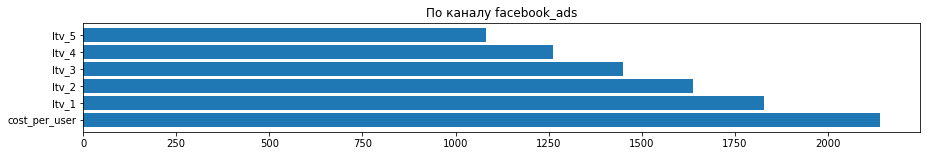

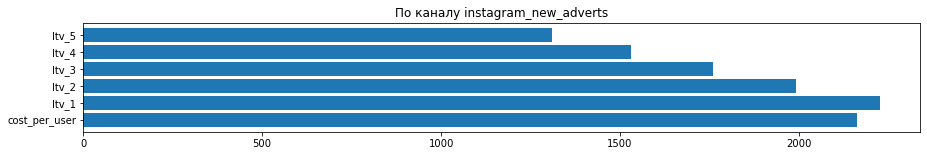

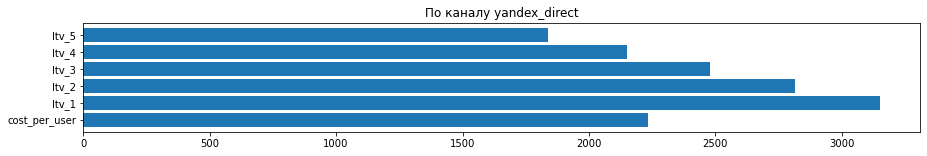

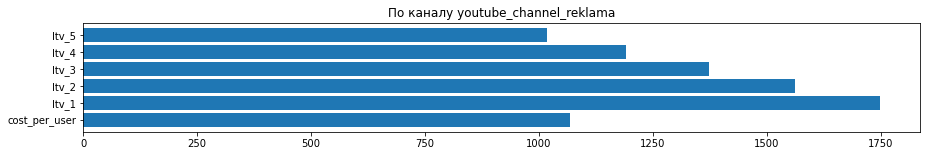

In [51]:
# визуализируем
for src in dft.index:
    plt.figure(figsize=(15,2))
    plt.barh(dft.columns.to_list(), dft.loc[src].to_frame()[src].to_list())
    plt.title(f'По каналу {src}')
    plt.show()

Прибыль по каналам привлечения

In [52]:
# функция для "подсвечивание" отрицательного значения
def style_negative(v, props=''):
    return props if v < 0 else None

In [53]:
for i in range(1, 6):
    col_name = 'ltv_' + str(i)
    dft[col_name] = dft[col_name] - dft['cost_per_user']
dft = dft.rename(
                columns={'cost_per_user':'cost_per_source',
                         'ltv_1':'income_1',
                         'ltv_2':'income_2',
                         'ltv_3':'income_3',
                         'ltv_4':'income_4',
                         'ltv_5':'income_5'})

dft.style.applymap(style_negative, props='color:red;').format("{:.2f}")

,cost_per_source,income_1,income_2,income_3,income_4,income_5
source,,,,,,
facebook_ads,2140.90,-311.73,-502.55,-692.39,-878.73,-1058.70
instagram_new_adverts,2161.44,65.61,-168.68,-402.20,-631.45,-851.11
yandex_direct,2233.11,919.13,581.94,246.08,-82.78,-396.73
youtube_channel_reklama,1068.12,680.34,492.32,305.21,122.79,-51.58


- `facebook_ads` Возможность заработка отсутствует даже, если начинать показ рекламы с 1 постройки. Причина - высокая стоимость привлечения.
- `instagram_new_adverts` Возможен небольшой доход при запуске рекламы с 1 постройки.
- `yandex_direct` `youtube_channel_reklama` Из-за более низкой стоимости привлечения для этих каналов, показ рекламы можно начинать с 3 и 4 постройки соответственно.

Определим доходность по типам игроков

In [54]:
dft = (
    df.groupby('user_type')
    .agg(
        {'cost_per_user':'sum', 
         'ltv_1' : 'sum', 
         'ltv_2' : 'sum', 
         'ltv_3' : 'sum', 
         'ltv_4' : 'sum', 
         'ltv_5' : 'sum'})).reset_index()
dft.index = dft['user_type']
dft.drop(columns='user_type', inplace=True)
dft.style.format("{:.2f}")

,cost_per_user,ltv_1,ltv_2,ltv_3,ltv_4,ltv_5
user_type,,,,,,
finished_pve,1052.87,1652.07,1521.45,1390.83,1260.21,1129.59
finished_pvp,2205.13,2602.95,2326.38,2049.81,1776.67,1510.60
not_finished,4345.58,4701.90,4158.77,3619.63,3096.52,2605.26


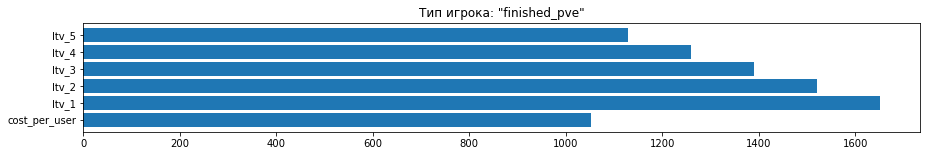

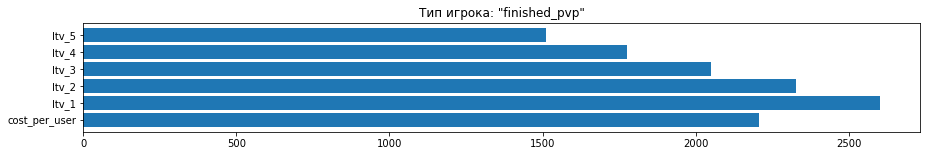

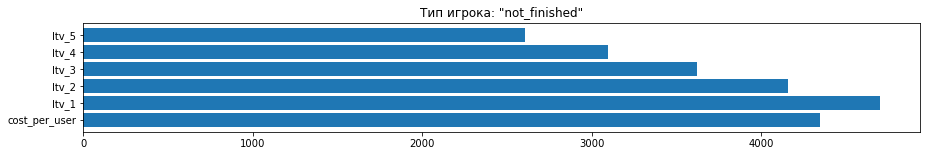

In [55]:
# визуализируем
for type in dft.index:
    plt.figure(figsize=(15,2))
    plt.barh(dft.columns.to_list(), dft.loc[type].to_frame()[type].to_list())
    plt.title(f'Тип игрока: "{type}"')
    plt.show()

Прибыль по типам игроков

In [56]:
for i in range(1, 6):
    col_name = 'ltv_' + str(i)
    dft[col_name] = dft[col_name] - dft['cost_per_user']
dft = dft.rename(
                columns={'cost_per_user':'cost_per_type',
                         'ltv_1':'income_1',
                         'ltv_2':'income_2',
                         'ltv_3':'income_3',
                         'ltv_4':'income_4',
                         'ltv_5':'income_5'})

dft.style.applymap(style_negative, props='color:red;').format("{:.2f}")

,cost_per_type,income_1,income_2,income_3,income_4,income_5
user_type,,,,,,
finished_pve,1052.87,599.20,468.58,337.96,207.34,76.72
finished_pvp,2205.13,397.82,121.25,-155.32,-428.46,-694.53
not_finished,4345.58,356.32,-186.81,-725.95,-1249.06,-1740.32


- Игроки завершившие уровень реализацией проекта (14% игроков PvE). Стратегия предусматривает большое число событий (построек). По-этому, ту есть существенный запас по времени начала показа рекламы. Даже если начинать показ с 5 постройки, игроки PvE будут приносить прибыль.
- Игроки завершившие уровень победой над врагом (29% игроков PvP). Картина схожа с анализом на общих данных, без разбивки по типам игроков). Ожидается прибыль при старте показа рекламы со 2 стройки.
- Игроки не завершившие уровень (57%). Прибыль возможна только при условии показа рекламы с первой постройки.

Посмотрим прибыль по дням привлечения

In [57]:
dft = (
    df.groupby('first_ts')
    .agg(
        {'cost_per_user':'sum', 
         'ltv_1' : 'sum', 
         'ltv_2' : 'sum', 
         'ltv_3' : 'sum', 
         'ltv_4' : 'sum', 
         'ltv_5' : 'sum'})).reset_index()
dft.index = dft['first_ts']
dft.drop(columns='first_ts', inplace=True)
for i in range(1, 6):
    col_name = 'ltv_' + str(i)
    dft[col_name] = dft[col_name] - dft['cost_per_user']
dft = dft.rename(
                columns={'cost_per_user':'cost_per_day',
                         'ltv_1':'income_1',
                         'ltv_2':'income_2',
                         'ltv_3':'income_3',
                         'ltv_4':'income_4',
                         'ltv_5':'income_5'})

dft.style.applymap(style_negative, props='color:red;').format("{:.2f}")

,cost_per_day,income_1,income_2,income_3,income_4,income_5
first_ts,,,,,,
2020-05-04 00:00:00,3302.45,942.00,531.80,122.23,-283.63,-681.79
2020-05-05 00:00:00,1865.00,427.29,192.02,-42.55,-273.62,-497.83
2020-05-06 00:00:00,1029.43,117.59,-11.70,-140.08,-265.94,-386.34
2020-05-07 00:00:00,620.48,2.80,-74.83,-152.11,-226.52,-294.00
2020-05-08 00:00:00,391.85,-53.12,-101.28,-148.81,-193.40,-232.46
2020-05-09 00:00:00,242.77,-42.85,-73.65,-104.10,-132.31,-156.46
2020-05-10 00:00:00,151.59,-40.36,-59.33,-77.88,-94.75,-109.24


Доли игроков по канам по дням примрно одинаковы. Поэтому, при неизменной стоимости привлечения, общий доход зависит от числа игроков. Видно, что 07-05-2020, когда число привлеченных игроков около 1100, расходы и дохооды почти равны. Для когорты размером 5860 (04-05-2020) прибыль сохраняется вплоть до 3 уровня начала показа рекламы.

## Проверка гипотез

**Уровень значимости.** Размер выборок в нашем случае достаточно велик, поэтому, можно принять уровень значимости 0.01.  
**Критерий проверки.** Для сравнения двух выборочных средних значений независимых выборок применяется t-критерий Стьюдента. У нас количественные переменные с нормальным распределением.

In [58]:
alpha = .01

###  Гипотеза о равенстве времени проходжения уровня для игроков PvE и PvP
H0: Среднее время прохождения уровня для PvE равно среднему времени прохождения укровня для PvP  
Н1: Среднее время прохождения уровня для PvE не равно среднему времени прохождения укровня для PvP 

Подготовим данные

In [59]:
# только игроки завершившие уровень
dft51 = profiles.query('user_id in @users_finished')
dft51.head(2)

,user_id,first_ts,source,cohort_size,cost_per_user
3,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05,instagram_new_adverts,796,0.631816
6,003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05,instagram_new_adverts,796,0.631816


In [60]:
# добавим даду завершения уровня
dft51 = dft51.merge(
    game_actions.query('event == "finished_stage_1"').loc[:, ['user_id', 'event_date']],
    on='user_id',
    how='left')
# расчитаем разницу между датой завершения уровня и датой первого действия
dft51['time_spent'] = (
    pd.DatetimeIndex(dft51['event_date']).date -
    pd.DatetimeIndex(dft51['first_ts']).date)
dft51.head()

,user_id,first_ts,source,cohort_size,cost_per_user,event_date,time_spent
0,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05,instagram_new_adverts,796,0.631816,2020-05-12,7 days
1,003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05,instagram_new_adverts,796,0.631816,2020-05-17,12 days
2,004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04,facebook_ads,1184,0.790442,2020-05-16,12 days
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,2020-05-04,yandex_direct,2078,0.466381,2020-05-15,11 days
4,0056c007-c082-43cc-bdef-afc49bca4cb9,2020-05-10,instagram_new_adverts,70,0.668220,2020-05-16,6 days


In [61]:
# добавим тип игрока
dft51 = dft51.merge(ev_by_users.loc[:, ['user_id', 'user_type']], on='user_id', how='left')
dft51.head()

,user_id,first_ts,source,cohort_size,cost_per_user,event_date,time_spent,user_type
0,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05,instagram_new_adverts,796,0.631816,2020-05-12,7 days,finished_pvp
1,003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05,instagram_new_adverts,796,0.631816,2020-05-17,12 days,finished_pvp
2,004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04,facebook_ads,1184,0.790442,2020-05-16,12 days,finished_pvp
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,2020-05-04,yandex_direct,2078,0.466381,2020-05-15,11 days,finished_pvp
4,0056c007-c082-43cc-bdef-afc49bca4cb9,2020-05-10,instagram_new_adverts,70,0.668220,2020-05-16,6 days,finished_pvp


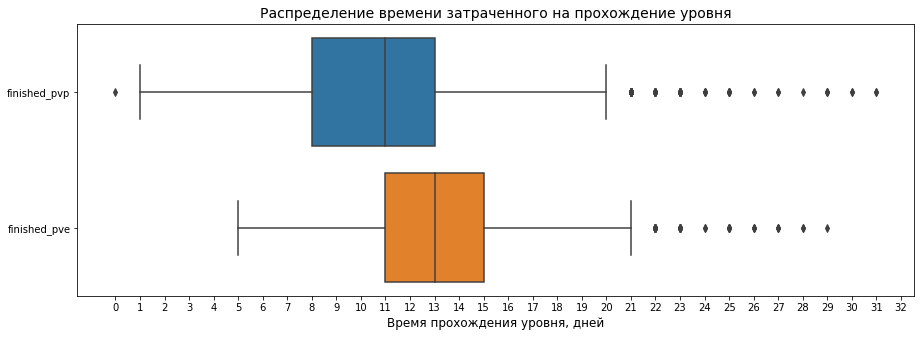

In [62]:
plt.figure(figsize=(15,5))
sns.boxplot(x=dft51['time_spent'].dt.days, y="user_type", data=dft51)
plt.title('Распределение времени затраченного на прохождение уровня', fontsize=14)
plt.xlabel('Время прохождения уровня, дней', fontsize=12)
plt.ylabel('', fontsize=12)
plt.xticks([x for x in range(0, 33)])
plt.show()


In [63]:
# формируем выборки
dft51_pve = dft51.query('user_type == "finished_pve"')
dft51_pvp = dft51.query('user_type == "finished_pvp"')
# посмотрим на их размер
print(f'Выборка PvE - {dft51_pve.shape[0]}, выборка PvP - {dft51_pvp.shape[0]}')

Выборка PvE - 1866, выборка PvP - 3951


Выборки имеют существенное различие в размере и их дисперсии могут быть не равны. Поэтому, сравнивая средние значения t-тестом, при вызове метода scipy.stats.ttest_ind(), укажем equal_var = False

In [64]:
results = stats.ttest_ind(dft51_pve['time_spent'].dt.days, dft51_pvp['time_spent'].dt.days, equal_var=False)
print('p-значение', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение 6.570466755643636e-105
Отвергаем нулевую гипотезу


p-значение ничтожно мало по сравнению с принятым уровнем значимости. Поэтому, гипотезу отвергаем.

### Гипотеза о равенстве доходов с игроков PvE и PvP
H0: Средние доходы с игроков PvE и PvP равны  
Н1: Средние доходы с игроков PvE и PvP не равны

In [65]:
df.head(2)

,user_id,first_ts,source,cohort_size,cost_per_user,buildings,user_type,ltv_1,ltv_2,ltv_3,ltv_4,ltv_5
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,2020-05-06,facebook_ads,345,0.754162,13,not_finished,0.91,0.84,0.77,0.70,0.63
1,00151b4f-ba38-44a8-a650-d7cf130a0105,2020-05-06,yandex_direct,664,0.464206,9,not_finished,0.63,0.56,0.49,0.42,0.35


In [66]:
# формируем выборки
dft52_pve = df.query('user_type == "finished_pve"')
dft52_pvp = df.query('user_type == "finished_pvp"')

In [67]:
results = stats.ttest_ind(dft52_pve['ltv_1'], dft52_pvp['ltv_1'], equal_var=False)
print('p-значение', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение 0.0
Отвергаем нулевую гипотезу


p-значение ничтожно мало по сравнению с принятым уровнем значимости. Поэтому, гипотезу отвергаем.

## Выводы

**На основании анализа полученных данных можно сделать следующие выводы:**

**Анализ игроков.** 
Из общего числа 13576 игроков около 43% (5817) завершили уровень. Доля игроков с PvE около 14%, а PvP - 29%.

Игроки PvE в среднем, тратят на прохождение уровня на 2 дня больше игроков PvP. Половина PvE проходит уровень за 11-15 дней, а PvP за 8-13. При этом в обеих группах наблюдаются выбросы более 21.

Активность растёт в период рекламы (с 1 по 10 число) после чего затухает. Динамика активности в разрезе по типам игроков практически идентична. Дольше всего сохраняется активность игроков PvP, вплоть до 05-06-2020.
- *PvE* От 12 жо 22 событий с медианой 14.
- *PvP* От 3 до 20 событий с медианой 11.
- *Игроки не завершившие уровень* От 1 до 20 событий с медианой 8. 

Большая доля всех событий - постройка (94% от общего числа событий).
- *PvE* от 10 до 18 построек с медианой 12 и двумя выбросами, 19 и 20.
- *PvP* от 2 до 18 построек с медианой 10 и выбросом 19. Диаграмма размаха симметрична.
- *Игроки не завершившие уровень* от 1 до 20 построек с медианой 8.  
Для групп, кроме PvE характерен "провал" по числу игроков с 7 постройками. Разница между числом игроков с 6 и 7 постройками почти в четырехкратная. Более 25% игроков не завершивших уровень и завершивших уровень PvP, потенциально могли его завершить стратегией PvE, так как у таких игроков более 12 построек, что выше медианного значения числа построек игроков, завершивших уровень PvE. 25% игроков не завершивших уровень имели столько же построек, сколько 50% завершивших уровень PvP.

Все игроки хотя бы раз запускали постройку, 75% игроков делало это более 6 раз, а половина от 6 до 12 раз.

Больше всего игроков, почти 6000, привлечено в первый день (04-05-2020). Дальше наблюдается равномерное снижение с коэффицентом 0.55-0.65 до 270 (10-05-2020).

**Анализ затрат на рекламу.**

* Больше всего игроков привлечено через yandex_direct, далее instagram_new_adverts и facebook_ads с youtube_channel_reklama. Первые 2 лидируют во все дни, последние 2 показывают примерно одинаковый результат. В первые 2-3 дня yandex_direct лидирует с существенным отрывом.  
* Самые дорогие каналы по стоимость привлечения - instagram_new_adverts и facebook_ads. Самый дешевый - youtube_channel_reklama. Стоимость привлечения одного игрока почти постоянна и не меняется во времени. 
* С точки зрения эффективности вложений, в лидерах yandex_direct. Так же стоит обратить внимание на youtube_channel_reklama. Хотя, канал и занимает 3-4 места по числу привлеченных клиентов, стоимость привлечения самая низкая, а самое значительное отставание по числу привлеченных игроков от instagram_new_adverts 20% (04-05-2020).

**Анализ доходов (модель монетизации).**

Проведено моделирование прибыли при разном времени запуска ракламы.

*Доходность по каналам привлечения*
- facebook_ads Возможность заработка отсутствует даже, если начинать показ рекламы с 1 постройки. Причина - высокая стоимость привлечения.
- instagram_new_adverts Возможен небольшой доход при запуске рекламы с 1 постройки.
- yandex_direct, youtube_channel_reklama Из-за более низкой стоимости привлечения для этих каналов, показ рекламы можно начинать с 3 и 4 постройки соответственно.

*Доходность по типам игроков*
- Игроки завершившие уровень реализацией проекта (14% игроков PvE). Стратегия предусматривает большое число событий (построек). Поэтому, ту есть существенный запас по времени начала показа рекламы. Даже если начинать показ с 5 постройки, игроки PvE будут приносить прибыль.
- Игроки завершившие уровень победой над врагом (29% игроков PvP). Картина схожа с анализом на общих данных, без разбивки по типам игроков). Ожидается прибыль при старте показа рекламы со 2 стройки.
- Игроки не завершившие уровень (57%). Прибыль возможна только при условии показа рекламы с первой постройки.

*Прибыль по дням привлечения*
Доли игроков по канам по дням примерно одинаковы. Поэтому, при неизменной стоимости привлечения, общий доход зависит от числа игроков. Так, для 07-05-2020, когда число привлеченных игроков около 1100, расходы и дохооды почти равны. А для когорты размером 5860 (04-05-2020) прибыль сохраняется вплоть до 3 уровня начала показа рекламы.

Моделирование по общим данным показывает, что для окупаемости вложений в рекламу нужно начинать ее показ не позже 2-ой стройки.

**Рекомендации**  
Для минимизации перегруженности рекламы, можно размещать ее при втором строительстве. В этом случае доходы от размещения должны превысить расходы на привлечение. При этом, существенное влияние на результат будут иметь такие факторы как число привлеченных игроков и каналы привлечения. 